# Example of shear-wave splitting applied to an SKS arrival

This example shows how the code can be applied to undertake shear-wave splitting analysis on SKS data. 


The data is from: 

J Asplet, J Wookey, M Kendall. (2020) "A potential post-perovskite province in D″ beneath the Eastern Pacific: evidence from new analysis of discrepant SKS–SKKS shear-wave splitting". GJI.

The example shown in this notebook has been reprocessed using a newer version of SHEBA, which packages shear-wave splitting results as NetCDF4 files. To perform the final comparison with the SHEBA measurements the follow additional package is required:
 - netCDF4 >= 1.6.4

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import swspy
import obspy
import os
from obspy import UTCDateTime
import numpy as np
# %matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
# import pathlib
# import netCDF4

## 1. Get event information from auxiliary files (specific to this dataset):

In [3]:
# Specify data directory:
datadir = os.path.join("data","data")


In [4]:
# Read in event window and back azimuth data:
aux_data_fname = os.path.join("data","Sheba_splitting_example_NEE.txt")
aux_data_df = pd.read_csv(aux_data_fname, delimiter=" ")


Before measuring shear-wave splitting, let's plot the waveforms and check the existing windows

AttribDict({'delta': 0.025, 'depmin': -3.2838732e-06, 'depmax': 8.5200099e-06, 'scale': 1.0, 'b': 1227.1106, 'e': 1587.0856, 'o': 0.0, 'a': 1412.1646, 'f': 1419.6008, 'stla': 34.824902, 'stlo': -114.59941, 'evla': 5.2895999, 'evlo': 123.4363, 'evdp': 540.40002, 'user0': 1409.4603, 'user1': 1412.1646, 'user2': 1419.2146, 'user3': 1420.0837, 'az': 48.837528, 'baz': 294.18597, 'gcarc': 112.45444, 'depmen': -5.4863909e-09, 'cmpaz': 90.0, 'cmpinc': 90.0, 'nzyear': 2005, 'nzjday': 36, 'nzhour': 12, 'nzmin': 23, 'nzsec': 18, 'nzmsec': 850, 'nvhdr': 6, 'npts': 14400, 'iftype': 1, 'iztype': 11, 'leven': 1, 'lpspol': 1, 'lovrok': 1, 'lcalda': 0, 'kstnm': 'NEE', 'kcmpnm': 'BHE', 'knetwk': 'CI'})

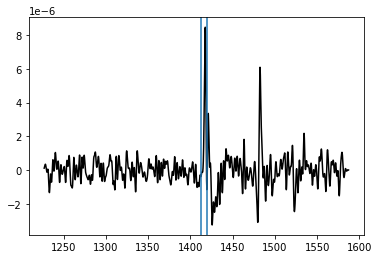

In [5]:
nee_example = obspy.read(os.path.join(datadir, 'NEE_2005036_122318_SKS.BH?'))
nee_example.filter("bandpass", freqmin=0.01, freqmax=0.5, zerophase=True)
# get time in seconds after event origin time. 'b' is a SAC header which stores this time 
time = nee_example[0].times() + nee_example[0].stats.sac['b']
fig, ax = plt.subplots()
ax.plot(time, nee_example[0].data, 'k')
ax.axvline(nee_example[0].stats.sac['a'])
ax.axvline(nee_example[0].stats.sac['f'])
nee_example[0].stats.sac


## Perform shear-wave splitting on event:
For this event we want to meausre the shear-wave splitting of two phases SKS and SKKS. In this instance we already have picks from Asplet et al., (2020), otherwise data would have to be picked in advance elsewhere. 

Successfully retreived sac info.
Automatically reads various data from sac files:
<load_wfs_obj.sac_info>:
{'event_uid': 'NEE_2005036_122318_SKS', 'stations': ['NEE'], 's_arrival_times': [UTCDateTime(2005, 2, 5, 13, 7, 18, 125146)], 'bazs': [294.18597412109375], 'incs': [0.0]}


/Users/eart0504/Documents/python/github_repositories/swspy/swspy/splitting/split.py:2131: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(os.path.join(outdir, ''.join((self.event_uid, "_", station, ".png"))), dpi=300)
/Users/eart0504/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


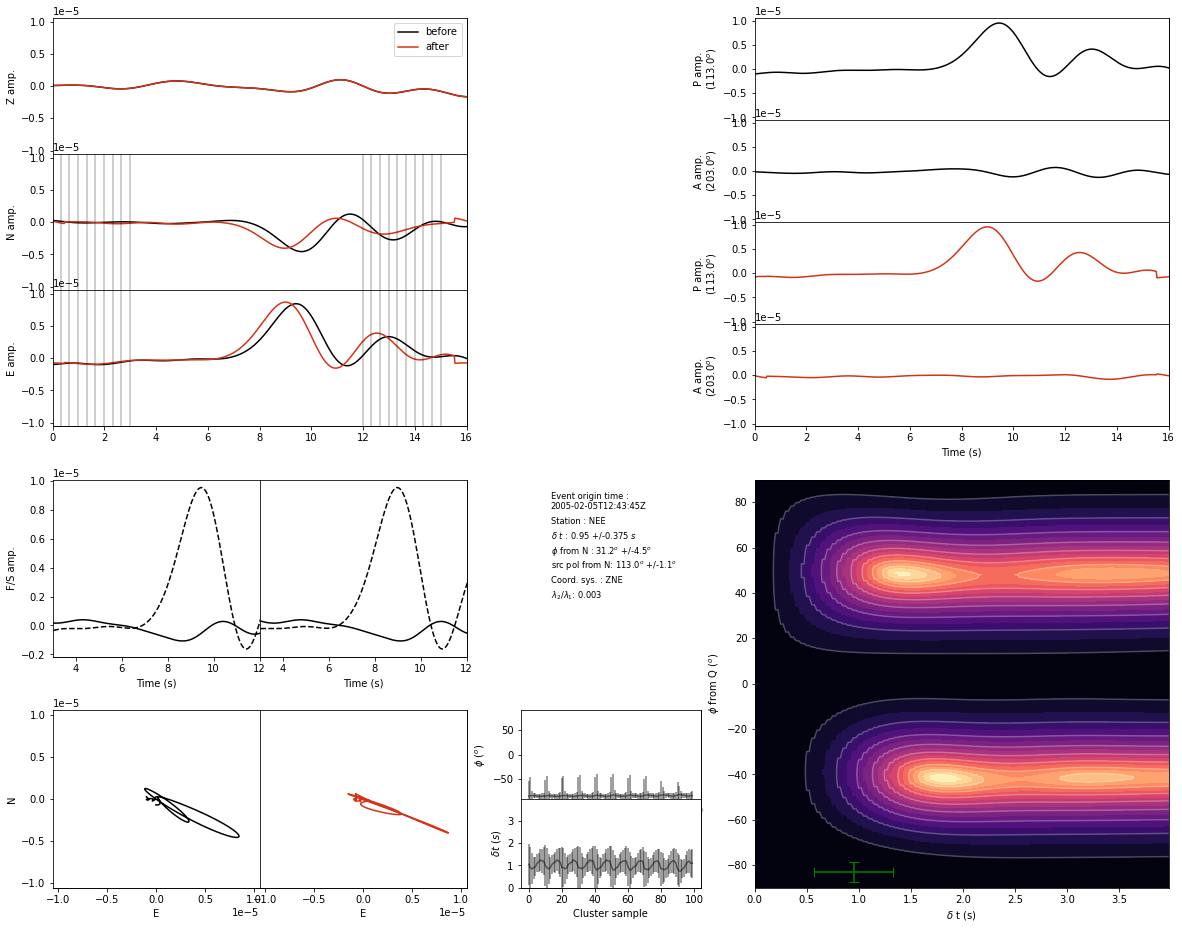

Saved sws result to: outputs/data/NEE_2005036_122318_SKS_sws_result.csv


In [7]:
# Specify event uid:
event_uid = "NEE_2005036_122318_SKS"
# (Other parameters read from sac headers)

# Load data:
mseed_path = os.path.join(datadir, event_uid)
load_wfs_obj = swspy.io.load_waveforms(mseed_path, archive_vs_file="file")
load_wfs_obj.sac = True
load_wfs_obj.sac_s_pick_hdr = 'a'
load_wfs_obj.filter = True
load_wfs_obj.filter_freq_min_max = [0.01, 0.5]
st = load_wfs_obj.read_waveform_data()
# And correct for S-arrival time since 'a' header is not referenced to zero, but to 'b' header:
S_phase_arrival_times = [st[0].stats.starttime + (nee_example[0].stats.sac['a'] - nee_example[0].stats.sac['b'])]
print("Automatically reads various data from sac files:")
print("<load_wfs_obj.sac_info>:")
print(load_wfs_obj.sac_info)

# Calculate splitting:
splitting_event_sks = swspy.splitting.create_splitting_object(st, event_uid=event_uid, stations_in=load_wfs_obj.sac_info['stations'], S_phase_arrival_times=S_phase_arrival_times,
                                                            back_azis_all_stations=load_wfs_obj.sac_info['bazs'],
                                                            receiver_inc_angles_all_stations=load_wfs_obj.sac_info['incs']) 
splitting_event_sks.overall_win_start_pre_fast_S_pick = 4.0
splitting_event_sks.win_S_pick_tolerance = 1.0
splitting_event_sks.overall_win_start_post_fast_S_pick = 8 
splitting_event_sks.rotate_step_deg = 1.0 
splitting_event_sks.max_t_shift_s = 4.0
splitting_event_sks.n_win = 10
splitting_event_sks.perform_sws_analysis(coord_system="ZNE", sws_method="EV")#, sws_method="EV_and_XC") 
# And plot splitting result:
splitting_event_sks.plot(outdir=os.path.join("outputs", "plots"))

# And save result to file:
splitting_event_sks.save_result(outdir=os.path.join("outputs", "data"))


    


Repeat measurment, now for SKKS

Successfully retreived sac info.
Automatically reads various data from sac files:
<load_wfs_obj.sac_info>:
{'event_uid': 'NEE_2005036_122318_SKKS', 'stations': ['NEE'], 's_arrival_times': [UTCDateTime(2005, 2, 5, 13, 8, 32, 136987)], 'bazs': [294.18597412109375], 'incs': [0.0]}


/Users/eart0504/Documents/python/github_repositories/swspy/swspy/splitting/split.py:2131: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(os.path.join(outdir, ''.join((self.event_uid, "_", station, ".png"))), dpi=300)
/Users/eart0504/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


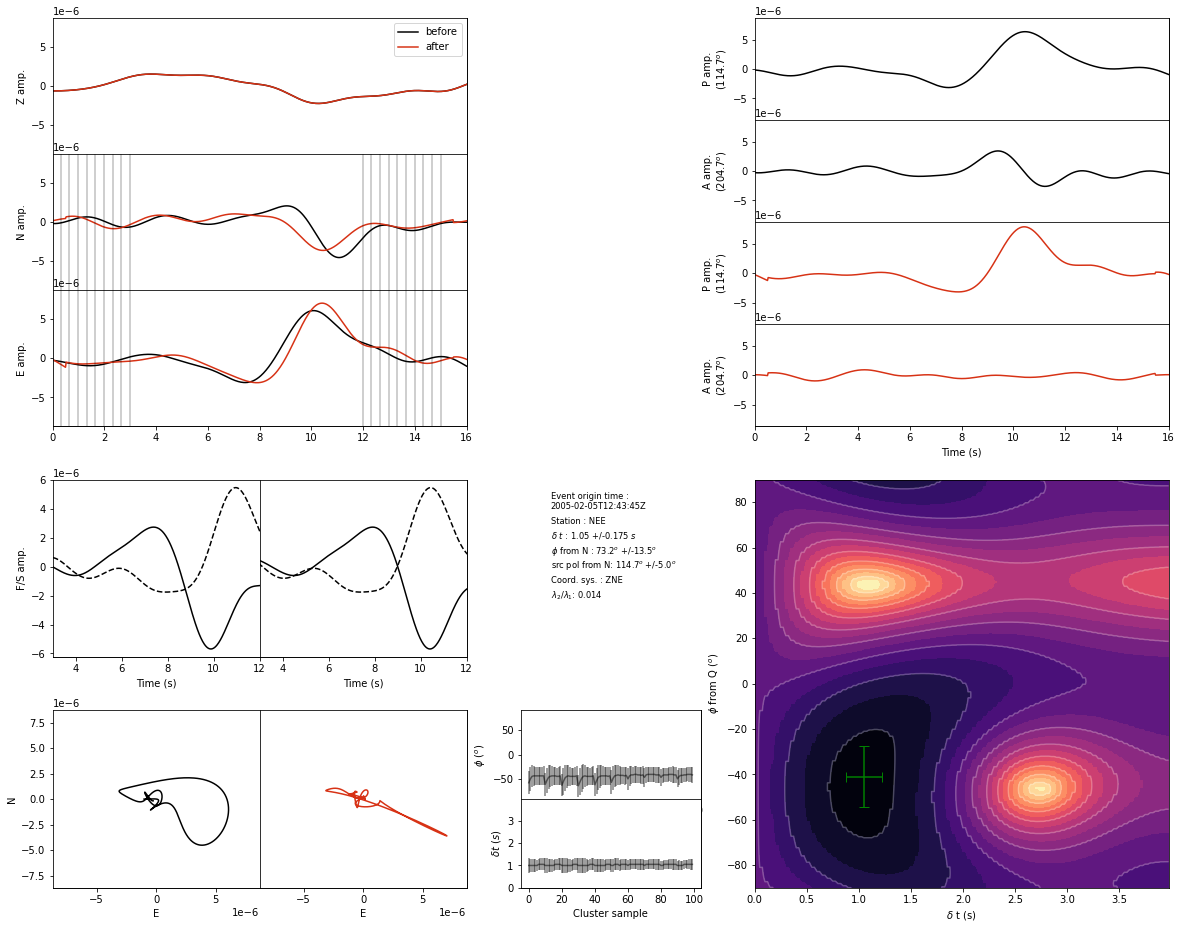

Saved sws result to: outputs/data/NEE_2005036_122318_SKKS_sws_result.csv


In [8]:
# Specify event uid:
event_uid = "NEE_2005036_122318_SKKS"
# (Other parameters read from sac headers)

# Load data:
mseed_path = os.path.join(datadir, event_uid)
load_wfs_obj = swspy.io.load_waveforms(mseed_path, archive_vs_file="file")
load_wfs_obj.sac = True
load_wfs_obj.sac_s_pick_hdr = 'f'
load_wfs_obj.filter = True
load_wfs_obj.filter_freq_min_max = [0.01, 0.5]
st = load_wfs_obj.read_waveform_data()
# And correct for S-arrival time since manually specified:
S_phase_arrival_times = [st[0].stats.starttime +  (1476.3104 - nee_example[0].stats.sac['b'])] # 
print("Automatically reads various data from sac files:")
print("<load_wfs_obj.sac_info>:")
print(load_wfs_obj.sac_info)

# Calculate splitting:
splitting_event_sks = swspy.splitting.create_splitting_object(st, event_uid=event_uid, stations_in=load_wfs_obj.sac_info['stations'], S_phase_arrival_times=S_phase_arrival_times,
                                                            back_azis_all_stations=load_wfs_obj.sac_info['bazs'],
                                                            receiver_inc_angles_all_stations=load_wfs_obj.sac_info['incs']) 
splitting_event_sks.overall_win_start_pre_fast_S_pick = 4.0
splitting_event_sks.win_S_pick_tolerance = 1.0
splitting_event_sks.overall_win_start_post_fast_S_pick = 8 
splitting_event_sks.rotate_step_deg = 1.0 
splitting_event_sks.max_t_shift_s = 4.0
splitting_event_sks.n_win = 10
splitting_event_sks.perform_sws_analysis(coord_system="ZNE", sws_method="EV")#, sws_method="EV_and_XC") 
# And plot splitting result:
splitting_event_sks.plot(outdir=os.path.join("outputs", "plots"))

# And save result to file:
splitting_event_sks.save_result(outdir=os.path.join("outputs", "data"))


## Compare to SHEBA result:

(Note: Commented out so that package doesn't require netcdf4 package. If user wishes to run this, then need to have netcdf4 installed to read SHEBA files in).

Plot results for NEE measured by SHEBA, these measurements were orionally made by Asplet et al., (2020) as part of a larger study of discpreant SKS-SKKS shear-wave splittiing in the Eastern Pacific.


In [9]:
# sheba_sks = netCDF4.Dataset('data/data/NEE_2005036_122318_SKS_result.nc')
# sheba_skks = netCDF4.Dataset('data/data/NEE_2005036_122318_SKKS_result.nc')

In [10]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5), sharex=True, sharey=True)
# phi_search = sheba_sks.variables['fast_vector'][:]
# dt_search = sheba_sks.variables['tlag_vector'][:]
# PHI, TLAG = np.meshgrid(phi_search, dt_search )
# l2l1_grid_sks = sheba_sks.variables['lam2_norm_grid'][:]

# C = ax1.contour(TLAG, PHI, l2l1_grid_sks, colors='black', levels=[1, 2, 5, 10, 15],
#                 linewidths = [3, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])
# ax1.clabel(C, C.levels, fmt ='%2i',fontsize=14)
# ax1.errorbar(sheba_sks.tlag, sheba_sks.fast, xerr=sheba_sks.dtlag, yerr=sheba_sks.dfast, fmt='b.')
# ax1.errorbar(splitting_event_sks.sws_result_df['dt'], splitting_event_sks.sws_result_df['phi_from_N'], xerr=splitting_event_sks.sws_result_df['dt_err'],
#              yerr=splitting_event_sks.sws_result_df['phi_err'], fmt='r.')
# ax1.set_yticks([-90,-60,-30,0,30,60,90])
# ax1.set_xticks([0, 1, 2, 3, 4])
# ax1.text(2,-10, f'ɸ = {sheba_sks.fast:3.0f}±{sheba_sks.dfast:2.0f}°',fontsize=14)
# ax1.text(1.95,-20,f'δt = {sheba_sks.tlag:3.2f}±{sheba_sks.dtlag:2.2f}$\,$s',fontsize=14)
# ax1.set_ylabel('ɸ from North [°]')
# ax1.tick_params(labelsize=12)
# ax1.set_title('NEE SKS Example')
# ax1.set_xlabel('Delay time [s]')
# # Plot SKKS example on second panel
# phi_search = sheba_skks.variables['fast_vector'][:]
# dt_search = sheba_skks.variables['tlag_vector'][:]
# l2l1_grid_skks = sheba_skks.variables['lam2_norm_grid'][:]

# C = ax2.contour(TLAG, PHI, l2l1_grid_skks, colors='black', levels=[1, 2, 5, 10, 15],
#                 linewidths = [3, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])
# ax2.text(2,-10, f'ɸ = {sheba_skks.fast:3.0f}±{sheba_skks.dfast:2.0f}°',fontsize=14, backgroundcolor='white')
# ax2.text(1.95,-20,f'δt = {sheba_skks.tlag:3.2f}±{sheba_skks.dtlag:2.2f}$\,$s',fontsize=14, backgroundcolor='white')
# ax2.clabel(C, C.levels, fmt ='%2i',fontsize=14)
# ax2.errorbar(sheba_skks.tlag, sheba_skks.fast,  xerr=sheba_skks.dtlag, yerr=sheba_skks.dfast, fmt='b.')
# ax2.errorbar(splitting_event_skks.sws_result_df['dt'], splitting_event_skks.sws_result_df['phi_from_N'], xerr=splitting_event_skks.sws_result_df['dt_err'],
#              yerr=splitting_event_skks.sws_result_df['phi_err'], fmt='r.')
# ax2.tick_params(labelsize=12)
# ax2.set_title('NEE SKKS Example')
# ax2.set_xlabel('Delay time [s]')

So we can see that the measured shear-wave splitting using SWSPY and SHEBA agree within meaurement errors. We can see from the shape of the normalised $\lambda_2/\lambda_1$ grid that the SKS phase is a null measurement - as it has the classic saddle shape. We can also see in the SWSPY particle motion output that the SKS particle motion is alreayd near-linear.